# Ocean heat content vs Zanna et al., PNAS 2019

This notebook plots the Ocean heat content change compared to Zanna et al., PNAS (2019)

In [1]:
import os
import datetime

In [2]:
config = {
    "startyr": "1975",
    "endyr": "2015",
    "dora_id": "odiv-319, odiv-362", # try with just "odiv-319" as well.
    "pathPP": None,
}

MAR will pass for environment variables to the script when running via the web engine:

* `MAR_STARTYR`: A `str` of the beginning year of analysis from model
* `MAR_ENDYR`: A `str` of the ending year of analysis from model
* `MAR_DORA_ID`: A `str` of the experiment ID in the database for a single experiment, e.g. `"odiv-1"`, or comma-separated experiments, e.g. `"odiv-1, odiv-2"`
* `MAR_PATHPP`: A `str` of the top-level path to the post-processing experiment directory of the experiment

The block below will use values passed in by Dora but default to the values defined above in `config`. This is useful for interactive usage and debugging.

If executed from Dora, there will also be a `DORA_EXECUTE` variable that is set.

In [3]:
for k, v in config.items():
    if f"MAR_{k.upper()}" in os.environ.keys():
        c = os.environ[f"MAR_{k.upper()}"]
    else:
        c = v
    if k=="dora_id" and (type(v) is not list): 
        c = [e.strip(" ") for e in c.split(",")]
    config[k] = c

### Import Python Modules

In [4]:
import doralite
import glob
import subprocess 

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cftime

In [5]:
# momgrid will use a directory of pre-computed weights
import momgrid
os.environ["MOMGRID_WEIGHTS_DIR"] = "/nbhome/John.Krasting/grid_weights"

### Define Local Parameters

In [6]:
# Define some local variables. These are taken from the doralite object
# or they can be defined locally

def get_local_params(config):
    experiments = {dora_id: doralite.dora_metadata(dora_id) for dora_id in config["dora_id"]}
    params = {
        dora_id: {
            "experiment": experiment,
            "pathPP": experiment["pathPP"],
            "expName": experiment["expName"]
        }
        for dora_id, experiment in experiments.items()
    }
    return params

start = int(config["startyr"])
end = int(config["endyr"])
params = get_local_params(config)

### Determine What Files to Load

In [7]:
# Determine what files are needed (leave this up to the developer for flexibility)
# This is an example of what someone might do:

component = "ocean_annual_z"
static = f"{component}/{component}.static.nc"
varnames = ["thetao", "volcello"]

chunk = "5yr"

list_of_filelists = []

for p in params.values(): # loop on experiments
    flist = []
    for varname in varnames: # loop on variables
        flist += glob.glob(f"{p['pathPP']}{component}/ts/**/{chunk}/{component}.*.{varname}.nc", recursive=True)
    list_of_filelists.append(flist)

In [8]:
def is_in_range(file,start,end):
    start = int(start)
    end = int(end)
    target = set(list(range(start,end+1)))
    fname = os.path.basename(file)
    times = fname.split(".")[1]
    times = times.split("-")
    times = [int(x[0:4]) for x in times]
    candidate = set(list(range(times[0],times[1]+1)))
    return len(candidate.intersection(target)) > 0

import itertools
list_of_filelists = [[x for x in filelist if is_in_range(x,start,end)] for filelist in list_of_filelists]
filelist = sorted(list(itertools.chain.from_iterable(list_of_filelists)))

staticfiles = [f"{p['pathPP']}/{static}" for p in params.values()]

_ = [print(x) for x in filelist]

/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/ts/annual/5yr/ocean_annual_z.1973-1977.thetao.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/ts/annual/5yr/ocean_annual_z.1973-1977.volcello.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/ts/annual/5yr/ocean_annual_z.1978-1982.thetao.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/ts/annual/5yr/ocean_annual_z.1978-1982.volcello.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-intel23-prod/pp/ocean_annual_z/ts/annual/5yr/ocean_annual_z.1983-1987.thetao.nc
/archive/Brandon.Reichl/fre_om5/FMS2023.01_om5_20230927/om5_b02_minthick1em3_MLErestart/gfdl.ncrc5-in

### DMgetting Files

Dora cannot issue calls to dmget

In [9]:
if not "DORA_EXECUTE" in os.environ.keys():
    print("Calling dmget on files ...")
    cmd = ["dmget"]+filelist+staticfiles
    _ = subprocess.check_output(cmd)

Calling dmget on files ...


### Load model data and grid

In [10]:
models = {}
for odiv, filelist, staticfile in zip(params.keys(), list_of_filelists, staticfiles):

    gds = momgrid.Gridset(filelist, force_symmetric=True, return_corners=True)
    gds.data = gds.data.sel(time=slice(f"{str(start).zfill(4)}-01-01",f"{str(end).zfill(4)}-12-31"))

    og = xr.open_dataset(staticfile)
    og = og.assign_coords({"xh":gds.data.xh, "yh":gds.data.yh})

    models[odiv] = {"gds":gds, "og":og}

### Load observational data (if needed)

Note that Dora only mounts `/archive`, `/nbhome`, and `/home`

In [11]:
obsfile = "/archive/Raphael.Dussin/datasets/OHC_Zanna/OHC_GF_1870_2018.nc"
Zanna = xr.open_dataset(obsfile)
Zanna = Zanna.rename({'time (starting 1870)': 'time'})
Zanna = Zanna.set_coords(['time'])
dates = []
for year in Zanna['time'].values:
    dates.append(cftime.DatetimeNoLeap(year, 7, 16, hour=12))
Zanna['time'] = xr.DataArray(np.array(dates), dims='time')

In [12]:
def compute_OHC(ds, rho0=1025, Cp=3850):
    """ compute OHC for various depths """
    slice_700 = {"z_l": slice(0,700)}
    slice_2000 = {"z_l": slice(0,2000)}
    slice_b2000 = {"z_l": slice(2000, None)}
    dims = ["xh", "yh", "z_l"]
    ohc = xr.Dataset()
    ohc["OHC_700m"] = rho0 * Cp * (ds["thetao"] * ds["volcello"]).sel(slice_700).sum(dim=dims)
    ohc["OHC_2000m"] = rho0 * Cp * (ds["thetao"] * ds["volcello"]).sel(slice_2000).sum(dim=dims)
    ohc["OHC_below_2000m"] = rho0 * Cp * (ds["thetao"] * ds["volcello"]).sel(slice_b2000).sum(dim=dims)
    ohc["OHC_full_depth"] = rho0 * Cp * (ds["thetao"] * ds["volcello"]).sum(dim=dims)
    return ohc

def relative_ohc_ZJ(ohc):
    return (ohc - ohc.isel(time=0)) / 1e21

def rebase_obs(da, dateref):
    return (da - da.sel(time=dateref).values[0]).sel(time=slice(dateref, None))

def plot_ohc(Zanna, models, config):
    """ plot 4 panels OHC """
    dateref = config["startyr"]

    f, axs = plt.subplots(ncols=2, nrows=2)

    # 0-700 meters
    rebase_obs(Zanna["OHC_700m"], dateref).plot(ax=axs[0,0], label="Zanna", color="k")
    for expname in models.keys():
        ohc_plt = relative_ohc_ZJ(ohc_models[expname]["OHC_700m"])
        ohc_plt.plot(ax=axs[0,0], label=expname)

    # 0-2000 meters
    rebase_obs(Zanna["OHC_2000m"], dateref).plot(ax=axs[0,1], label="Zanna", color="k")
    for expname in models.keys():
        ohc_plt = relative_ohc_ZJ(ohc_models[expname]["OHC_2000m"])
        ohc_plt.plot(ax=axs[0,1], label=expname)

    # 2000-bottom meters
    rebase_obs(Zanna["OHC_below_2000m"], dateref).plot(ax=axs[1,0], label="Zanna", color="k")
    for expname in models.keys():
        ohc_plt = relative_ohc_ZJ(ohc_models[expname]["OHC_below_2000m"])
        ohc_plt.plot(ax=axs[1,0], label=expname)

    # full depth
    rebase_obs(Zanna["OHC_full_depth"], dateref).plot(ax=axs[1,1], label="Zanna", color="k")
    for expname in models.keys():
        ohc_plt = relative_ohc_ZJ(ohc_models[expname]["OHC_full_depth"])
        ohc_plt.plot(ax=axs[1,1], label=expname)

    # common cosmetics
    for ax in axs.flatten():
        ax.grid()
        ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_xlim([cftime.datetime(int(dateref),1,1),
                     cftime.datetime(2018,12,31)])

    # plot by plot changes
    axs[0,0].set_title("0-700 meters [ZJ]")
    axs[0,1].set_title("0-2000 meters [ZJ]")
    axs[1,0].set_title("below 2000 meters [ZJ]")
    axs[1,1].set_title("full depth [ZJ]")
    axs[0,1].legend(bbox_to_anchor=[1.6, 0.2])
    axs[1,0].set_xlabel("year")
    axs[1,1].set_xlabel("year")

    plt.subplots_adjust(hspace=0.4)

In [13]:
%%capture
ohc_models = {}
for expname, ds in models.items():
    ohc_exp = compute_OHC(ds["gds"].data)
    ohc_exp.load()
    ohc_models[expname] = ohc_exp

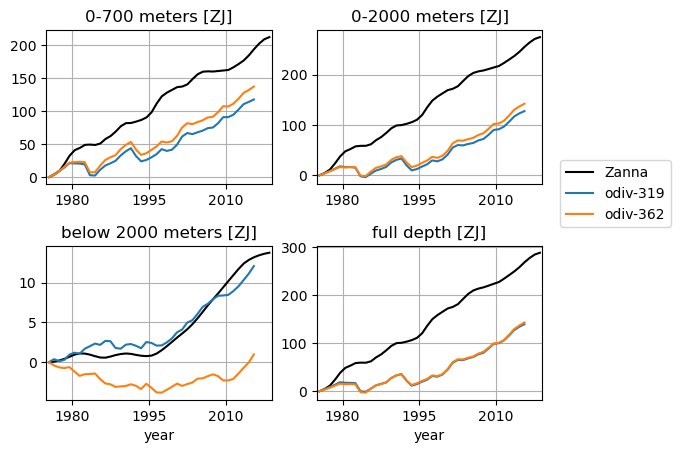

In [14]:
plot_ohc(Zanna, models, config)